# Table of Contents
* [1 Introduction](#1-introduction)
* [2 Importing Relevant Packages](#2-importing-relevant-packages)
* [3 Function Definitions](#3-function-definitions)
* [4 Preparing the Data](#4-preparing-the-data)
* [5 Using Bayesian Networks as Classifiers](#5-using-bayesian-networks-as-classifiers)  
    * [5.1 Classification Using Hill Climb Search](#51-classification-using-hill-climb-search)
        * [5.1.1 Classification Algorithm](#511-classification-algorithm)
        * [5.1.2 Classification Results](#512-classification-results)
        * [5.1.3 Model DAG](#513-model-dag)
    * [5.2 Classification Using PC](#52-classification-using-pc)  
    * [5.3 Classification Using Mmhc](#53-classification-using-mmhc)
        * [5.3.1 Classification Algorithm](#531-classification-algorithm)
        * [5.3.2 Classification Results](#532-classification-results)
        * [5.3.3 Model DAG](#533-model-dag)  
    * [5.4 Comparison with Non-Causal Classifier](#54-comparison-with-non-causal-classifier)  
        * [5.4.1 Classification Algorithm](#541-classification-algorithm)  
        * [5.4.2 Classification Results](#542-classification-results)
        
* [6 Cross-Validation of the Bayesian Model Classifiers](#6-cross-validation-of-the-bayesian-network-classifiers)  
    * [6.1 Cross-Validation](#61-cross-validation)
    * [6.2 Cross-Validation Results](#62-cross-validation-results)
* [7 Structure Score of Models](#7-structure-score-of-models)
    * [7.1 Training of the Models](#71-training-the-models)
        * [7.1.1 Hill Climb Search](#711-hill-climb-search)
        * [7.1.2 Mmhc](#712-mmhc)
    * [7.2 Bar Plot of Structure Score Results](#72-bar-plot-of-structure-score-results)
* [8 Causal Inference](#8-causal-inference)
    * [8.1 Generating Queries](#81-generating-queries)
    * [8.2 Results](#82-results)
        * [8.2.1 Query Results](#821-query-results)
        * [8.2.2 Comparison of Probabilities With and Without Interventions](#822-comparison-of-probabilites-with-and-without-interventions)
* [9 Summary and Conclusions](#9-summary-and-conclusions)

# 1 Introduction
In this project, we will use data about the prevalence of health conditions in a sample of the U.S. population to build causal models that can describe the data; specifically, we will build Bayesian Network models. Because these models are causal, it goes beyond simply discovering correlations in the data to potentially discovering whether the correlations in the data are due to a causal mechanism. In other words, the models might be able to establish whether one of the features is the "cause" of another feature, the "effect". 

The causal relationships between the features of the data are summarized in a so-called "directed acyclic graph", or DAG. The name implies that the nodes in the graph that represent the features are always joined by directed edges pointing from the "cause" to the "effect", and that there are no cycles in the graph, meaning that if you start from any node in the graph and move along the nodes by following the edges in the directions that they point you will never arrive at the node you started from. The models that we will use in this project will have as one of their outputs a DAG.

We have three main purposes when building these causal models. First, we will use the models as classifiers to predict the class of a feature in data not used to train the model. Second, we want to discover the causal connections between the features of the data; these will be summarized in the DAGs that are part of the outputs of the models. Third, we want to use these models to do causal inference, which means making predictions about the probability that a feature is observed in the population if a so-called intervention is carried out. In an intervention, the probability distribution of the data is first changed so that the values of the features that are intervened on are first set to specific values with probability 1 and then the probability of another feature being observed is found.

# 2 Importing Relevant Packages

In [1]:
import os
import pandas as pd
import numpy as np
import pickle

# 3 Function Definitions

In [2]:
from pgmpy.models.BayesianNetwork import BayesianNetwork
from pgmpy.estimators import StructureEstimator, BayesianEstimator, HillClimbSearch, PC, MmhcEstimator
from sklearn.preprocessing import LabelEncoder

class BayesianModel(BayesianNetwork):
    '''
    Wrapper class that gives pgmp's Bayesian Network class an interface that makes it compatible with
    scikit-learn. The object gets initialized with a graph search algorithm, an estimator for fitting 
    the network parameters, and the parameters needed for these two previously mentioned algorithms.
    '''
    

    def __init__(self, *, 
        ebunch=None,
        n_jobs = -1, 
        graph_search_algo=HillClimbSearch, 
        
        scoring_method='k2score', 
        start_dag=None, 
        fixed_edges=set(), 
        tabu_length=100, 
        max_indegree=None, 
        black_list=None, 
        white_list=None, 
        epsilon=0.0001, 
        max_iter=1000000.0, 
        show_progress=True, 

        variant='stable',
        ci_test='chi_square',
        max_cond_vars=5,
        return_type='dag',
        significance_level=0.01,

        estimator=BayesianEstimator, 
        prior_type='BDeu', 
        pseudo_counts=[], 
        equivalent_sample_size=5
        ):
        '''
        The initialization parameters are the graph search algorithm, the estimator used
        for finding the Table CPD parameters of each node, and the parameters needed for these 
        two previously mentioned algorithms.

        A lot of the parameters will not apply to the graph search alogrithm and
        estimator chosen. In that case, the default values should be left intact.
        '''        

        #Currently, the model cannot be initialized with a PDAG.
        if graph_search_algo == PC and return_type in ['pdag', 'cpdag']:
            raise ValueError('BayesianModel currently has no support for PDAG\'s')

        super().__init__(ebunch)
        
        #Parameters relevant to the HillClimbSearch graph search algorithm.
        self.ebunch = ebunch
        self.n_jobs = n_jobs
        self.graph_search_algo = graph_search_algo
        self.scoring_method = scoring_method
        self.start_dag = start_dag
        self.fixed_edges = fixed_edges
        self.tabu_length = tabu_length
        self.max_indegree = max_indegree
        self.black_list = black_list
        self.white_list = white_list
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.show_progress = show_progress

        #Parameters relevant to the PC graph search algorithm.
        self.variant = variant
        self.ci_test = ci_test
        self.max_cond_vars = max_cond_vars
        self.return_type = return_type
        self.significance_level = significance_level

        #Parameters related to the estimator used for finding the
        #Table CPD parameters of each node.
        self.estimator = estimator
        self.prior_type = prior_type
        self.pseudo_counts = pseudo_counts
        self.equivalent_sample_size = equivalent_sample_size

    def fit(self, X_train, y_train, **fit_params):
        '''
        Finds the graph and the Table CPD parameters of it.
        '''
        
        data = pd.concat([X_train, y_train], axis=1)
        
        graph_search_est = self.graph_search_algo(data)
        if self.graph_search_algo == HillClimbSearch:
            parameters = dict(
                scoring_method=self.scoring_method,
                start_dag=self.start_dag,
                fixed_edges=self.fixed_edges,
                tabu_length=self.tabu_length,
                max_indegree=self.max_indegree,
                black_list=self.black_list,
                white_list=self.white_list,
                epsilon=self.epsilon,
                max_iter=self.max_iter,
                show_progress=self.show_progress
            )
        elif self.graph_search_algo == PC:
            parameters = dict(
                variant=self.variant,
                ci_test=self.ci_test,
                max_cond_vars=self.max_cond_vars,
                return_type=self.return_type,
                significance_level=self.significance_level,
                show_progress=self.show_progress
            )
        elif self.graph_search_algo == MmhcEstimator:
            parameters = dict(
                scoring_method=self.scoring_method, 
                tabu_length=self.tabu_length, 
                significance_level=self.significance_level
            )

        #Run graph search algorithm to find the graph.
        dag = graph_search_est.estimate(**parameters)

        #Sometimes, there are columns that don't end up on the
        #found graph.
        extra_columns = list(set(data.columns) - set(dag.nodes))
        if y_train.name in extra_columns:
            raise ValueError('Resulting DAG does not contain target. It cannot be used to make predictions.')
        if len(extra_columns) > 0:
            data = data.drop(columns=extra_columns)
        elif len(extra_columns) < 0:
            raise ValueError('Invalid value for extra_columns')
        
        self._dag = dag
        self.ebunch = list(dag.nodes)

        super().__init__(dag)
        print('Now fitting the graph...')
        
        #Finding the Table CPD parameters of the graph.
        super().fit(
            data, 
            estimator=self.estimator, 
            prior_type=self.prior_type, 
            pseudo_counts=self.pseudo_counts,
            equivalent_sample_size=self.equivalent_sample_size,
            n_jobs = self.n_jobs,
            **fit_params
        )
        print('Succesfully fitted the graph')

        self.X_ = X_train
        self.y_ = y_train
        self.fit_params_ = fit_params
        self.classes_ = LabelEncoder().fit(y_train).classes_

        return self

    def predict(self, X, stochastic=False, n_jobs=None):
        '''
        Given a dataframe with the features, predicts the values of
        the target.
        '''

        if n_jobs == None:
            n_jobs = self.n_jobs
        extra_columns = list(set(X.columns) - set(self.nodes))
        if len(extra_columns) > 0:
            X = X.drop(columns=extra_columns)
        elif len(extra_columns) < 0:
            raise ValueError('Invalid value for extra_columns')
        
        y_pred_df = super().predict(X, stochastic, n_jobs)
        y_pred = y_pred_df.to_numpy()
        self.y_pred_ = y_pred

        return y_pred

    def predict_proba(self, X):
        '''
        Given a dataframe with the features, predicts the probability
        of each class of the target.
        '''

        extra_columns = list(set(X.columns) - set(self.nodes))
        if len(extra_columns) > 0:
            X = X.drop(columns=extra_columns)
        elif len(extra_columns) < 0:
            raise ValueError('Invalid value for extra_columns')
        
        y_pred_proba_df = super().predict_probability(X)
        y_pred_proba = y_pred_proba_df.to_numpy()
        self.y_pred_proba_ = y_pred_proba
        
        return y_pred_proba
    
    def get_params(self, deep=True):

        return {
            'ebunch':self.ebunch,
            'graph_search_algo':self.graph_search_algo,
            'scoring_method':self.scoring_method,
            'start_dag':self.start_dag,
            'fixed_edges':self.fixed_edges,
            'tabu_length':self.tabu_length,
            'max_indegree':self.max_indegree,
            'black_list':self.black_list,
            'white_list':self.white_list,
            'epsilon':self.epsilon,
            'max_iter':self.max_iter,
            'show_progress':self.show_progress,
            'variant':self.variant,
            'ci_test':self.ci_test,
            'max_cond_vars':self.max_cond_vars,
            'return_type':self.return_type,
            'significance_level':self.significance_level,
            'estimator':self.estimator,
            'prior_type':self.prior_type,
            'pseudo_counts':self.pseudo_counts,
            'equivalent_sample_size':self.equivalent_sample_size,
            'n_jobs':self.n_jobs
        }
    
    def set_params(self, **parameters):
        
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [3]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

def cv_scorer(ml_algo, scoring, *data, model_name=None, algo_params={}, resampler=None, output=True):
    '''
    Given an algorithm and a dictionary with its parameters, a list of scoring methods, a dataframe 
    of features, a target, a name for the algorithm, and possibly a resampler, applies cross-validation.
    It returns the dictionary of results returned by the sklearn function cross_validate, as well as a
    "summary" dictionary that contains the average values found on each cross-valicaton fold.
    '''
    
    if len(data) == 2:
        X, y = tuple(data)
        w = None
    elif len(data) == 3:
        X, y, w = tuple(data)
    else:
        print('Invalid length for "data".')
        return
    
    if resampler != None:
        model = Pipeline([('Resampling', resampler()), (model_name, ml_algo(**algo_params))])
    else:
        model = Pipeline([(model_name, ml_algo(**algo_params))])
    
    cv_scores = cross_validate(model, X, y, scoring=scoring, fit_params={}, return_estimator=True)
    
    if output == True:
        if type(model_name) != type(None):
            print(model_name + ' cv_scores:')
        else:
            print('cv_scores:')
        print(cv_scores)
        print()
    
    cv_scores_summary = {}
    cv_scores_summary['estimator'] = cv_scores['estimator']
    for score in scoring:
        scores_ = cv_scores['test_' + score]
        mean_ = cv_scores['test_' + score].mean()
        std_ = cv_scores['test_' + score].std()
        
        cv_scores_summary[score]= dict(zip(['scores', 'mean', 'std'], [scores_, mean_, std_]))
        
        if output == True:
            print(score + ' mean: ' + f'{mean_:0.2f}')
            print(score + ' std: ' + f'{std_:0.4f}')
            print()
    if print == True:
        print()
    
    return cv_scores_summary, cv_scores

In [4]:
def no_parents_black_list(list_orig, list_no_parents):
    '''Given a list of nodes, list_orig, and another list of nodes that should not have parents, 
    list_no_parents, generates the required black_list for use in graph search algorithms'''

    list_start = []
    list_end = []
    for node_no_parent in list_no_parents:
        list_temp_1 = list_orig.copy()
        list_temp_1.remove(node_no_parent)
        list_temp_2 = [node_no_parent] * len(list_temp_1)
        list_start.append(list_temp_1)
        list_end.append(list_temp_2)
    assert len(list_start) == len(list_end)
    
    black_list = []
    for i in range(len(list_start)):
        black_list = black_list + list(zip(list_start[i], list_end[i]))

    return black_list

In [5]:
from sklearn.metrics import roc_curve

def find_threshold(fpr_chosen, y_test, y_proba):
    '''
    Find the threshold value in the ROC curve given a desired
    false positive rate.
    '''

    fpr, _, thresholds= roc_curve(y_test, y_proba)
    indices = np.where(fpr <= fpr_chosen)[0]
    index = indices[-1:-2:-1][0] + 1
    return thresholds[index]

def predict_with_treshold(proba, threshold):
    '''
    For given probabilites and probability threshold, predict
    the class of the target.
    '''

    return (proba >= threshold).astype(float)

In [6]:
def value_counts(df, dropna=True):
    '''
    For each column in a dataframe, print the value counts.
    '''

    for column in df.columns:
        print(df[column].value_counts(dropna=dropna), '\n')

In [7]:
def drop_low_counts(df, threshold, ignored_columns=[], verbose=False):
    '''
    If a particular class of a feature happens too unfrequently, it might not appear 
    in both sets when using train-test split. This could cause problems for some 
    algorithms, such as the PC algorithms.

    This function finds feature classes that occur in the dataframe less than a given
    fraction of the total number of rows. It then drops all of the rows that contain
    at least one of these classes.
    '''
    
    #Initialize list of columns to ignore
    if isinstance(ignored_columns, str):
        ignored_columns = [ignored_columns]
    elif not isinstance(ignored_columns, list):
        raise TypeError('ignored_columns must be either str or list.')
    if verbose:
        if len(ignored_columns) == 0:
            print('No columns chosen to ignore')
        else:
            print('Columns to ignore:', *ignored_columns)
    n_rows = df.shape[0]

    #For each column not in ignored_columns, find values to drop
    to_drop = []
    for column in df.columns:
        if column not in ignored_columns:
            counts = df[column].value_counts(dropna=False)
            for value, count in counts.items():
                proportion = count / n_rows
                if proportion <= threshold:
                    to_drop.append((column, value))
    if len(to_drop) == 0:
        if verbose:
            print('No rows to drop')
        return df
    if verbose:
        print('Column-value pairs to drop:', *to_drop)

    #Find filter to use on the dataframe
    filter = np.array([False] * df.shape[0])
    for column, value in to_drop:
        filter = filter | (df[column] == value)
    drop_indices = df[filter].index
    df_new = df.drop(drop_indices).reset_index(drop=True)

    #Extra information to print out if verbose == True
    if verbose == True:
        n_rows_dropped = n_rows - df_new.shape[0]
        percent_dropped = round(n_rows_dropped / n_rows * 100, 2)
        print('Number of rows dropped:', n_rows_dropped)
        print('Percentage of rows dropped:', percent_dropped)

    return df_new

In [8]:
def classification_results(y_test, y_pred, y_proba, pos_label, title=None):
    import matplotlib.pyplot as plt
    from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, classification_report, ConfusionMatrixDisplay

    RocCurveDisplay.from_predictions(y_test, y_proba[:, 1], pos_label=pos_label)
    if title != None:
        plt.title(title + " ROC Curve")
    plt.show()
    
    PrecisionRecallDisplay.from_predictions(y_test, y_proba[:, 1], pos_label=pos_label)
    if title != None:
        plt.title(title + " Precision Recall Curve")
    plt.show()
    
    if title != None:
        print(title + " Classification Report")
    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
    if title != None:
        plt.title(title + " Confusion Matrix (Normalized over true values)")
    plt.show()

# 4 Preparing the Data

Load the cleaned dataframe

In [9]:
with open('../Data/dataframe_clean.pkl', 'rb') as f:
    df = pickle.load(f)

df.columns

Index(['Good_Health', 'Health_Insurance', 'Hypertension', 'High_Cholesterol',
       'Asthma_Status', 'Arthritis', 'Race', 'Age_Cat', 'BMI_Cat',
       'Education_Level', 'Income_Level', 'Smoker_Status', 'Heavy_Drinker',
       'Physical_Activity', 'Seatbelt', 'Flu_Shot', 'Pneumonia_Vaccine', 'HIV',
       'Bronchitis', 'Depression', 'Kidney_Disease', 'Diabetes', 'SEX',
       'Marital_Status', 'Sodium', 'Heart_Disease', 'Sample_Weights'],
      dtype='object')

To make the model simpler to interpret, only a few of the features will be included when building the graph. The most important ten features, according to calculated SHAP values, were chosen.

In [10]:
included_columns = ['Good_Health', 'Hypertension', 'High_Cholesterol', 'Smoker_Status', 'Age_Cat', 'Diabetes', 'Sodium', 'Heavy_Drinker', 'Heart_Disease', 'SEX', 'Sample_Weights']
df = df[included_columns]

df

,Good_Health,Hypertension,High_Cholesterol,Smoker_Status,Age_Cat,Diabetes,Sodium,Heavy_Drinker,Heart_Disease,SEX,Sample_Weights
0,2.0,1.0,1.0,3.0,5.0,2.0,999.0,2.0,0.0,2.0,341.384853
1,1.0,2.0,2.0,1.0,4.0,2.0,2.0,2.0,0.0,2.0,108.060903
3,2.0,1.0,1.0,4.0,5.0,2.0,2.0,2.0,0.0,2.0,341.384853
4,2.0,2.0,2.0,4.0,5.0,2.0,2.0,2.0,0.0,2.0,258.682223
5,1.0,1.0,2.0,4.0,6.0,2.0,2.0,2.0,0.0,2.0,256.518591
...,...,...,...,...,...,...,...,...,...,...,...
441451,2.0,1.0,1.0,4.0,6.0,1.0,1.0,2.0,0.0,2.0,531.980410
441452,1.0,2.0,2.0,4.0,2.0,2.0,2.0,2.0,0.0,2.0,746.416599
441453,2.0,1.0,1.0,3.0,6.0,2.0,999.0,2.0,0.0,2.0,207.663634
441454,1.0,1.0,2.0,4.0,4.0,2.0,1.0,2.0,0.0,1.0,515.758894


Change the values of the dataframe to string type. For reasons that are not known at the moment, integer and float values make the PC algorithm not run effectively.

In [11]:
df['Heart_Disease'] = df['Heart_Disease'].cat.remove_unused_categories()
df = df.astype(int).astype(str)

Separate the dataframe into a features dataframe and target series.

In [12]:
X = df.drop(columns=['Heart_Disease', 'Sample_Weights'])
y = df['Heart_Disease']

Creating a list of edges that are not allowed to appear when using the HillClimbSearch algorithm. Specifically, the node `SEX` and `Age_Cat` (age category) will not be allowed to have parents since it is obvious that the other features are not the direct causes of them.

In [13]:
black_list = no_parents_black_list(list(pd.concat([X, y], axis=1).columns), ['SEX', 'Age_Cat'])
black_list

[('Good_Health', 'SEX'),
 ('Hypertension', 'SEX'),
 ('High_Cholesterol', 'SEX'),
 ('Smoker_Status', 'SEX'),
 ('Age_Cat', 'SEX'),
 ('Diabetes', 'SEX'),
 ('Sodium', 'SEX'),
 ('Heavy_Drinker', 'SEX'),
 ('Heart_Disease', 'SEX'),
 ('Good_Health', 'Age_Cat'),
 ('Hypertension', 'Age_Cat'),
 ('High_Cholesterol', 'Age_Cat'),
 ('Smoker_Status', 'Age_Cat'),
 ('Diabetes', 'Age_Cat'),
 ('Sodium', 'Age_Cat'),
 ('Heavy_Drinker', 'Age_Cat'),
 ('SEX', 'Age_Cat'),
 ('Heart_Disease', 'Age_Cat')]

# 5 Using Bayesian Networks as Classifiers
The following algorithms will construct Bayesian Network models from the data and then use them to predict the class of a target feature. They involve two steps:  
    1. Learn the structure from the data (the directed acyclic graph, or DAG).  
    2. Fit the parameters of the probability distribution function implied by the found DAG.  

The algorithms for structure learning are divided into two classes:  
    1. Score-based algorithms.  
    2. Contraint-based algorithms.  
    
Score-based algorithms make use of a score function that quantifies the degree to which a graph can reproduce the probability distribution implied by the data. There are many such scoring functions. Constraint-based algorithms make use of hypothesis tests for independencies between subsets of features conditional on other features. Since a DAG implies independence relations between the variables represented by the nodes, the results of these hypothesis tests can be used to construct the DAG.

Creating the train and test sets. The training sets will also be randomly undersampled.

In [14]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

X_train_res, y_train_res = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)

X_train_res.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train_res.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

## 5.1 Classification using Hill Climb Search

### 5.1.1 Classification Algorithm

In [15]:
path = '../Data/bm_hc_predictions.pkl'
if os.path.exists(path):
    with open(path, 'rb') as f:
        _ = pickle.load(f)
        bm_hc = pickle.load(f)
        y_test = pickle.load(f)
        y_pred = pickle.load(f)
        y_proba = pickle.load(f)
        print(f'Loaded from {path}.')
else:
    from pgmpy.estimators import HillClimbSearch, BayesianEstimator

    bm_hc = BayesianModel(graph_search_algo=HillClimbSearch, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5, black_list=black_list)
    bm_hc.fit(X_train_res, y_train_res)
    y_pred = bm_hc.predict(X_test)
    y_proba = bm_hc.predict_proba(X_test)
    
    with open(path, 'wb') as f:
        pickle.dump(4, f)
        pickle.dump(bm_hc, f)
        pickle.dump(y_test, f)
        pickle.dump(y_pred, f)
        pickle.dump(y_proba, f)
    print('Model trained.')

Loaded from ../Data/bm_hc_predictions.pkl.


### 5.1.2 Classification Results

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

model_name = 'Hill Climb Search'

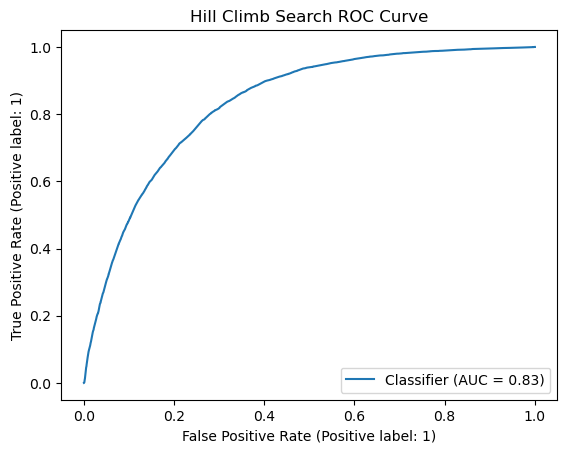

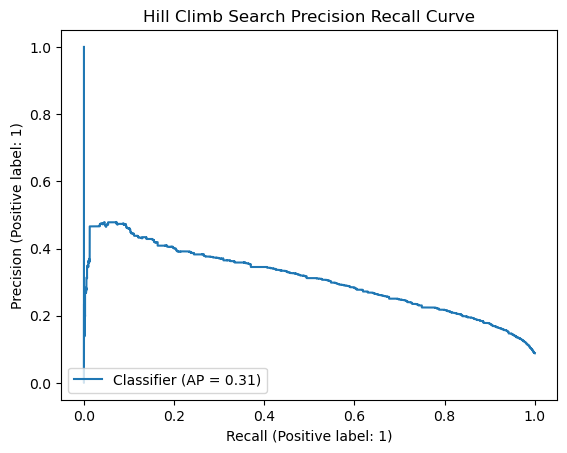

Hill Climb Search Classification Report
              precision    recall  f1-score   support

           0       0.97      0.71      0.82     79776
           1       0.21      0.81      0.34      7727

    accuracy                           0.72     87503
   macro avg       0.59      0.76      0.58     87503
weighted avg       0.91      0.72      0.78     87503



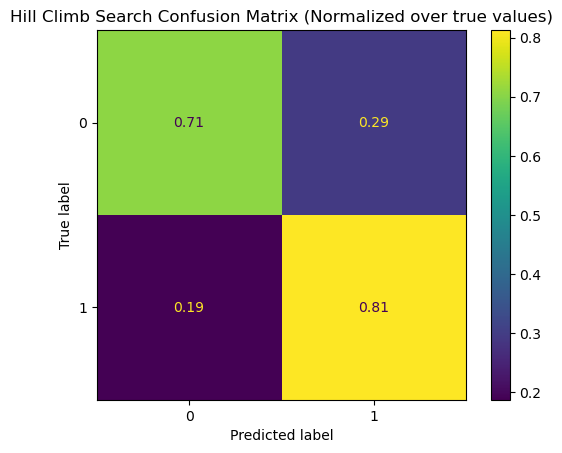

In [17]:
classification_results(y_test, y_pred, y_proba, pos_label='1', title=model_name)

### 5.1.3 Model DAG

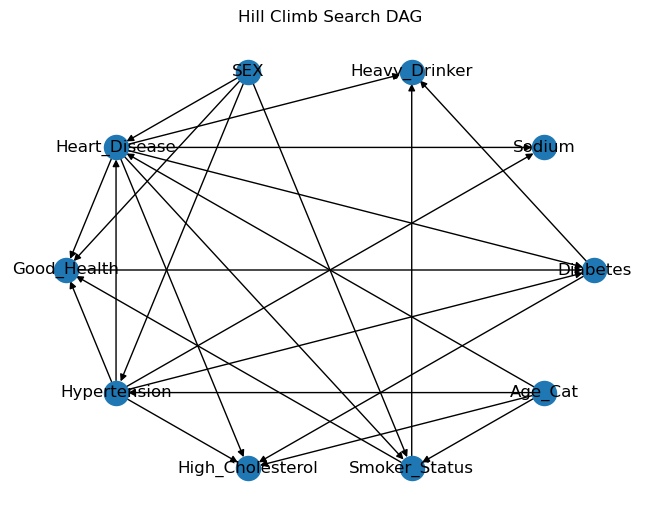

In [18]:
nx.draw_shell(bm_hc, with_labels=True)
plt.title('Hill Climb Search DAG')
plt.show()

## 5.2 Classification Using PC
This project ran into a hurdle when using the constraint-based algorithm PC. The output of the algorithm should be a DAG; as implied by its name, it should not have cycles. However, for reasons that are still not understood, the output of the algorithm consistently gives us a DAG that contains a cycle. This DAG is not accepted as a valid network as input to initialize a BayesianNetwork model and, therefore, it cannot be used to make predictions. This might be due to a problem with the implementation of the algorithm in the pgmpy library.

An attempt was also made to find instead the Class PDAG (partial directed acyclic graph), which is a graph that represents an equivalence class of graphs that can all represent the conditional independencies found in the data. If there is a directed edge between two variables in all of the DAGs in the equivalence class, then this edge will also be found in the Class PDAG. On the other hand, if the direction of an edge is not always the same in different DAGS in the equivalence class, then this edge will be undirected in the Class PDAG. 

When the PC algorithm was used to find the Class PDAG, the output was instead a proper DAG that had one cycle. As previously mentioned, if a directed graph has cycles, it cannot be used as a model to make predictions.

The source of this problem will be further investigated in a future study.

Initializing PC algorithm object

In [19]:
path_pc_dag = '../Data/pc_dag.pkl'
path_pc_cpdag = '../Data/pc_cpdag.pkl'
path_pc_dag_exists = os.path.exists(path_pc_dag)
path_pc_cpdag_exists = os.path.exists(path_pc_cpdag)

if (not path_pc_dag_exists) or (not path_pc_cpdag_exists):
    pc_algo = PC(pd.concat([X_train_res, y_train_res], axis=1))

Running PC algorithm with DAG output. The resulting graph is not actually a dag because it contains a cycle.

Model loaded
Cycles found:
[('Age_Cat', 'Heart_Disease'), ('Heart_Disease', 'Smoker_Status'), ('Smoker_Status', 'High_Cholesterol'), ('High_Cholesterol', 'Age_Cat')]


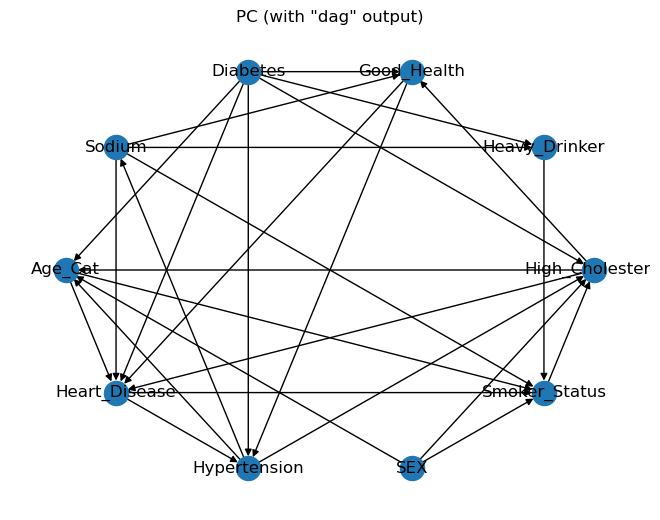

In [20]:
if not path_pc_dag_exists:
    import warnings
    
    warnings.filterwarnings('ignore', category=FutureWarning)
    
    pc_dag = pc_algo.estimate(variant='orig', max_cond_vars=5, return_type='dag')
    print('Model Trained')
    with open(path_pc_dag, 'wb') as f:
        pickle.dump(pc_dag, f)
else:
    with open(path_pc_dag, 'rb') as f:
        pc_dag = pickle.load(f)
    print('Model loaded')

print('Cycles found:')
print(nx.find_cycle(pc_dag))

nx.draw_shell(pc_dag, with_labels=True)
plt.title('PC (with "dag" output)')
plt.show()

Running the PC algorithm with a Class PDAG output. A Class PDAG is allowed to have some of its edges undirected. The resulting graph happens to have all edges directed. However, this graph also ended up having a cycle, which is not allowed in a Class PDAG.

Model loaded
Cycles found:
[('Heart_Disease', 'High_Cholesterol'), ('High_Cholesterol', 'Good_Health'), ('Good_Health', 'Hypertension'), ('Hypertension', 'Heart_Disease')]


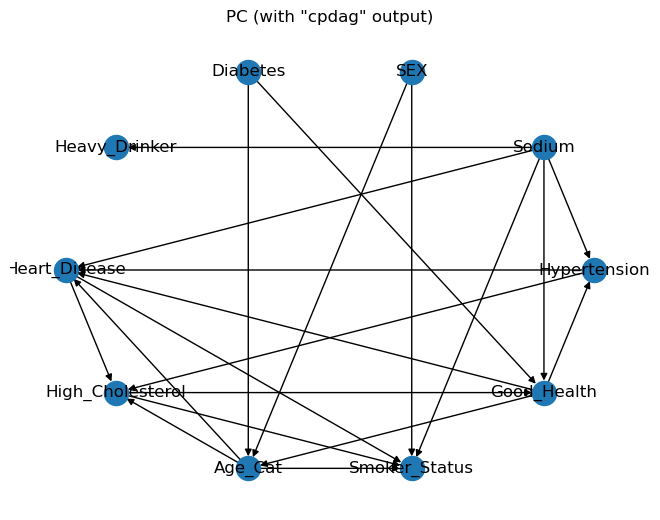

In [21]:
if not path_pc_cpdag_exists:
    import warnings
    
    warnings.filterwarnings('ignore', category=FutureWarning)
    
    pc_cpdag = pc_algo.estimate(variant='orig', max_cond_vars=5, return_type='cpdag')
    print('Model Trained')
    with open(path_pc_cpdag, 'wb') as f:
        pickle.dump(pc_cpdag, f)
else:
    with open(path_pc_cpdag, 'rb') as f:
        pc_cpdag = pickle.load(f)
    print('Model loaded')

print('Cycles found:')
print(nx.find_cycle(pc_cpdag))

nx.draw_shell(pc_cpdag, with_labels=True)
plt.title('PC (with "cpdag" output)')
plt.show()

## 5.3. Classification Using Mmhc  
The Mmhc algorithm is a combination of both the score-based and constraint-based approaches to structure learning. A constraint-based approach is used to first find the skeleton of the graph, which is the graph where all of the edges are undirected. Then, it uses scoring functions to orient the edges in a way that maximizes the score.

### 5.3.1 Classification Algorithm

In [22]:
path = '../Data/bm_mmhc_predictions.pkl'
if os.path.exists(path):
    with open(path, 'rb') as f:
        _ = pickle.load(f)
        bm_mmhc = pickle.load(f)
        y_test = pickle.load(f)
        y_pred = pickle.load(f)
        y_proba = pickle.load(f)
        print(f'Loaded from {path}.')
else:
    from pgmpy.estimators import BayesianEstimator
    import warnings

    warnings.filterwarnings('ignore', category=FutureWarning)

    bm_mmhc = BayesianModel(graph_search_algo=MmhcEstimator, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5, black_list=black_list)
    bm_mmhc.fit(X_train_res, y_train_res)
    y_pred = bm_mmhc.predict(X_test)
    y_proba = bm_mmhc.predict_proba(X_test)
    
    with open(path, 'wb') as f:
        pickle.dump(4, f)
        pickle.dump(bm_mmhc, f)
        pickle.dump(y_test, f)
        pickle.dump(y_pred, f)
        pickle.dump(y_proba, f)
    print('Model trained.')

Loaded from ../Data/bm_mmhc_predictions.pkl.


### 5.3.2 Classification Results

In [23]:
model_name = 'Mmhc'

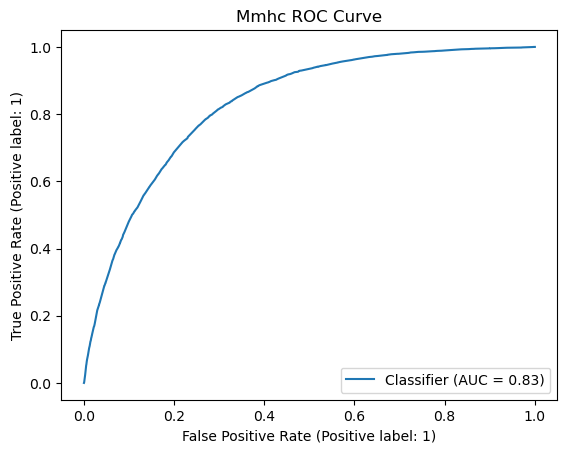

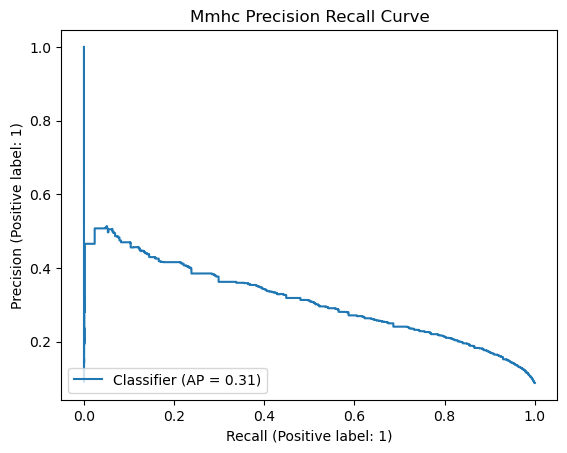

Mmhc Classification Report
              precision    recall  f1-score   support

           0       0.97      0.72      0.83     79776
           1       0.21      0.80      0.34      7727

    accuracy                           0.72     87503
   macro avg       0.59      0.76      0.58     87503
weighted avg       0.91      0.72      0.78     87503



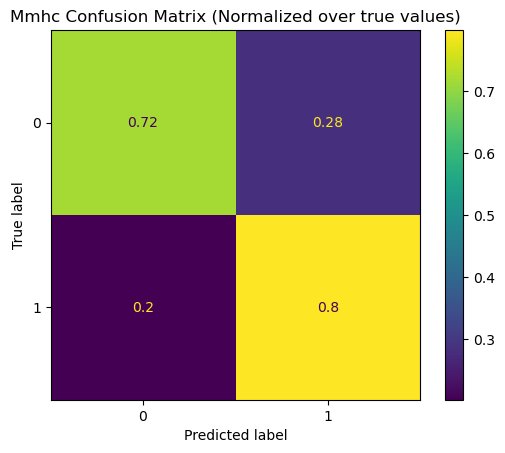

In [24]:
classification_results(y_test, y_pred, y_proba, pos_label='1', title=model_name)

### 5.3.3 Model DAG

Text(0.5, 1.0, 'Mmhc DAG')

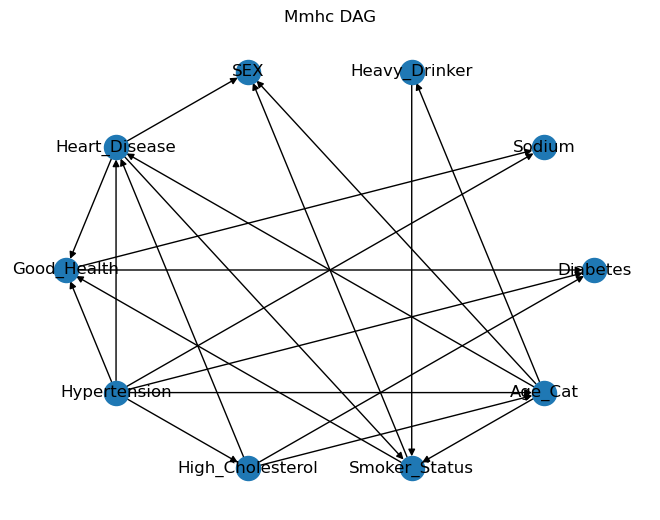

In [25]:
import networkx as nx

nx.draw_shell(bm_mmhc, with_labels=True)
plt.title(model_name + " DAG")

## 5.4 Comparison with Non-Causal Classifier

### 5.4.1 Classification Algorithm

In [26]:
path = '../Data/xgboost_predictions.pkl'
if os.path.exists(path):
    with open(path, 'rb') as f:
        _ = pickle.load(f)
        xgboost = pickle.load(f)
        y_test = pickle.load(f)
        y_pred = pickle.load(f)
        y_proba = pickle.load(f)
        print(f'Loaded from {path}.')
else:
    from xgboost import XGBClassifier

    xgboost = XGBClassifier(max_depth=3, eta=0.3, reg_lambda=10)
    xgboost.fit(X_train_res.astype(int), y_train_res.astype(int))
    y_pred = xgboost.predict(X_test.astype(int))
    y_proba = xgboost.predict_proba(X_test.astype(int))
    
    with open(path, 'wb') as f:
        pickle.dump(4, f)
        pickle.dump(xgboost, f)
        pickle.dump(y_test, f)
        pickle.dump(y_pred, f)
        pickle.dump(y_proba, f)
    print('Model trained.')

Loaded from ../Data/xgboost_predictions.pkl.


### 5.4.2 Classification Results

In [27]:
model_name = 'XGBoost'

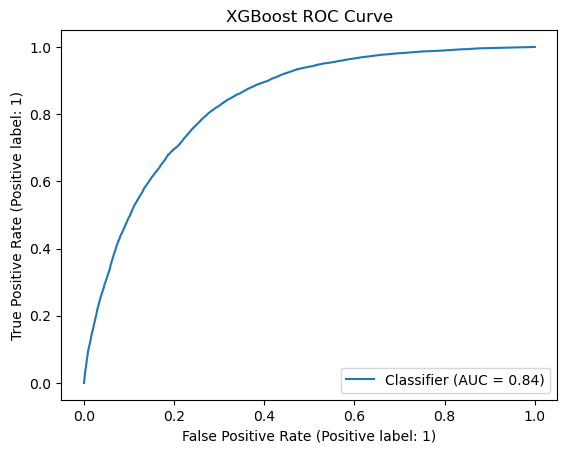

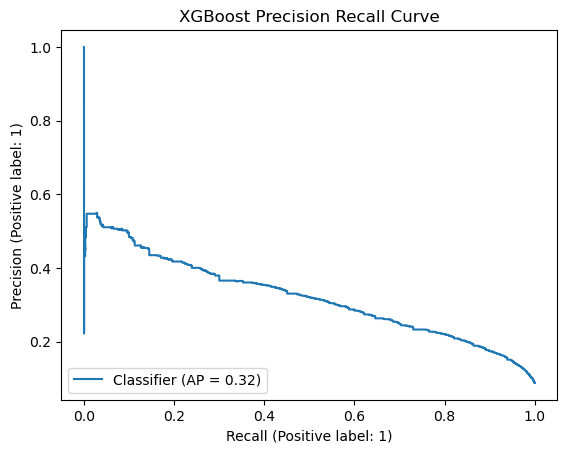

XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.98      0.71      0.82     79776
           1       0.22      0.81      0.34      7727

    accuracy                           0.72     87503
   macro avg       0.60      0.76      0.58     87503
weighted avg       0.91      0.72      0.78     87503



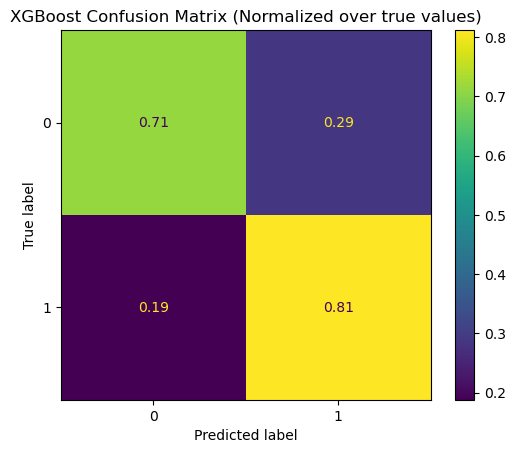

In [28]:
classification_results(y_test.astype(int), y_pred, y_proba, pos_label=1, title=model_name)

# 6 Cross-Validation of the Bayesian Network Classifiers
The classification models built on the previous part of this project will be cross-validated.

## 6.1 Cross-Validation

In [29]:
from pgmpy.estimators import BayesianEstimator
from sklearn.metrics import make_scorer, roc_auc_score, recall_score
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler

Making scorer objects. They will be using the cross-validation algorithm to give a classification score. The recall score will be used because in this particular case, we want the false negative rate to be as low as possible. The roc auc score will be used because it is independent of any chosen classification threshold.

In [30]:
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
recall_scorer = make_scorer(recall_score, pos_label='1')

Making a list of parameters that will be passed to the cross-validation algorithm. The algorithm will cycle through each of the parameters of the list; each cycle corresponds to one model to be cross-validated.

In [31]:
scoring = {'recall':recall_scorer, 'roc_auc':roc_auc_scorer}
model_names = ['HillClimbSearch', 'Mmhc']
algo_params_list = [
    dict(graph_search_algo=HillClimbSearch, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5, black_list=black_list), 
    dict(graph_search_algo=MmhcEstimator, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5)]
resamplers = [RandomUnderSampler, RandomUnderSampler]

Dropping rows that have features with values that don't occur frequently. It was found that this could cause problems when the algorithms are run.

In [32]:
temp_df = drop_low_counts(pd.concat([X, y], axis=1), 0.01, verbose=True)
X_drop = temp_df.drop(columns='Heart_Disease')
y_drop = temp_df['Heart_Disease']
del(temp_df)

No columns chosen to ignore
Column-value pairs to drop: ('Good_Health', '9') ('Hypertension', '9') ('High_Cholesterol', '9') ('Diabetes', '7') ('Diabetes', '9') ('Diabetes', '999') ('Sodium', '7') ('Sodium', '9')
Number of rows dropped: 6334
Percentage of rows dropped: 1.45


Cross-validation algorithm

In [33]:
path = '../Data/cv_scores.pkl'
if os.path.exists(path):
    with open(path, 'rb') as f:
        _ = pickle.load(f)
        cv_scores_summary = pickle.load(f)
        cv_scores = pickle.load(f)
        print('Loaded cv scores')
else:
    cv_scores_summary = {}
    cv_scores = {}
    for model_name, algo_params, resampler in zip(model_names, algo_params_list, resamplers):
        cv_scores_summary[model_name], cv_scores[model_name] = cv_scorer(BayesianModel, scoring, X_drop, y_drop, model_name=model_name, algo_params=algo_params, resampler=resampler)
    print('Model trained')
    
    with open(path, 'wb') as f:
        pickle.dump(2, f)
        pickle.dump(cv_scores_summary, f)
        pickle.dump(cv_scores, f)

Loaded cv scores


## 6.2 Cross-Validation Results

Making dataframe summarizing results

In [34]:
results_df = pd.DataFrame()
for model_name, results in cv_scores_summary.items():
    for score in scoring.keys():
        series = pd.Series([results[score]['mean'], results[score]['std']], name=model_name + '_' + score, index=['mean', 'std'])
        results_df = pd.concat([results_df, series], axis=1)
results_df = results_df.T
results_df

,mean,std
HillClimbSearch_recall,0.811704,0.006513
HillClimbSearch_roc_auc,0.833428,0.002845
Mmhc_recall,0.806547,0.007368
Mmhc_roc_auc,0.832680,0.003252


Making bar plot summarizing results

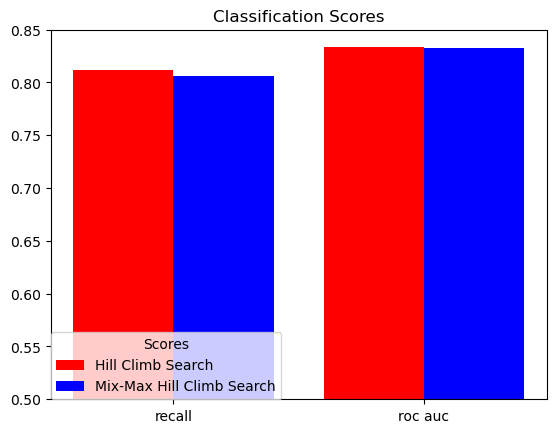

In [35]:
import matplotlib.pyplot as plt

initial_positions = [1,3]
bar_width = 0.8
positions = []
x_tick_positions = []
x_tick_labels = ['recall', 'roc auc']
plot_title = 'Classification Scores'
legend_title = 'Scores'
for i in initial_positions:
    group_positions = [i + j * bar_width for j in range(2)]
    x_tick_position = group_positions[0] + (group_positions[-1] - group_positions[0]) / 2
    x_tick_positions.append(x_tick_position)
    positions.append(group_positions)
xs = zip(*positions)
colors = ['red', 'blue']
labels = ['Hill Climb Search', 'Mix-Max Hill Climb Search']
heights = [(results_df.iloc[0, 0], results_df.iloc[1, 0]), (results_df.iloc[2, 0], results_df.iloc[3,0])]
for x, h, c, l in zip(xs, heights, colors, labels):
    plt.bar(x, h, width=bar_width, color=c, label=l)
plt.legend(title=legend_title, loc=(0, 0))
plt.xticks(x_tick_positions, labels=x_tick_labels)
plt.ylim((0.5, 0.85))
plt.title(plot_title)
plt.show()

# 7 Structure Score of Models
In this part of the project, we will evaluate model performance not on its ability to predict correctly the class of a feature, but rather based on a structure score. Given a graph and given some data, the graph can be given a score based on how well the conditional independencies implied by the graph are found in the data. Three of these scores are the BDeu score, the K2 score, and the Bic score. All of them give negative values, and the higher the score, the better. The bar plot below shows the absolute value of these scores; therefore, the lower the value, the better. Since now we are not dealing with a classification problem, the models will be retrained with the entire dataset.

## 7.1 Training the Models

### 7.1.1 Hill Climb Search

In [36]:
path = '../Data/structure_scores_hc.pkl'

if os.path.exists(path):
    structure_scores_hc = {}
    with open(path, 'rb') as f:
        _ = pickle.load(f)
        bm_hc = pickle.load(f)
        structure_scores_hc = pickle.load(f)
        print('Loaded model and structure scores')
else:
    from pgmpy.estimators import BayesianEstimator, BDeuScore, K2Score, BicScore

    df_ = pd.concat([X, y], axis=1)
    bdeu = BDeuScore(df_, equivalent_sample_size=5)
    k2 = K2Score(df_)
    bic = BicScore(df_)

    bm_hc = BayesianModel(graph_search_algo=HillClimbSearch, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5, black_list=black_list)
    bm_hc.fit(X, y)
    print('Model Trained')

    structure_scores_hc = {}
    structure_scores_hc['bdeu'] = bdeu.score(bm_hc)
    structure_scores_hc['k2'] = k2.score(bm_hc)
    structure_scores_hc['bic'] = bic.score(bm_hc)

    with open(path, 'wb') as f:
        pickle.dump(2, f)
        pickle.dump(bm_hc, f)
        pickle.dump(structure_scores_hc, f)

Loaded model and structure scores


### 7.1.2 Mmhc

In [37]:
path = '../Data/structure_scores_mmhc.pkl'

if os.path.exists(path):
    structure_scores_mmhc = {}
    with open(path, 'rb') as f:
        _ = pickle.load(f)
        bm_mmhc = pickle.load(f)
        structure_scores_mmhc = pickle.load(f)
        print('Loaded model and structure scores')
else:
    from pgmpy.estimators import BayesianEstimator, BDeuScore, K2Score, BicScore

    df_ = pd.concat([X, y], axis=1)
    bdeu = BDeuScore(df_, equivalent_sample_size=5)
    k2 = K2Score(df_)
    bic = BicScore(df_)

    bm_mmhc = BayesianModel(graph_search_algo=MmhcEstimator, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5, black_list=black_list)
    bm_mmhc.fit(X, y)
    print('Model Trained')

    structure_scores_mmhc = {}
    structure_scores_mmhc['bdeu'] = bdeu.score(bm_mmhc)
    structure_scores_mmhc['k2'] = k2.score(bm_mmhc)
    structure_scores_mmhc['bic'] = bic.score(bm_mmhc)

    with open(path, 'wb') as f:
        pickle.dump(2, f)
        pickle.dump(bm_mmhc, f)
        pickle.dump(structure_scores_mmhc, f)

Loaded model and structure scores


## 7.2 Bar Plot of Structure Score Results

The results imply that the MMhc model is the better model in terms of being able to represent the conditional dependencies found in the data.

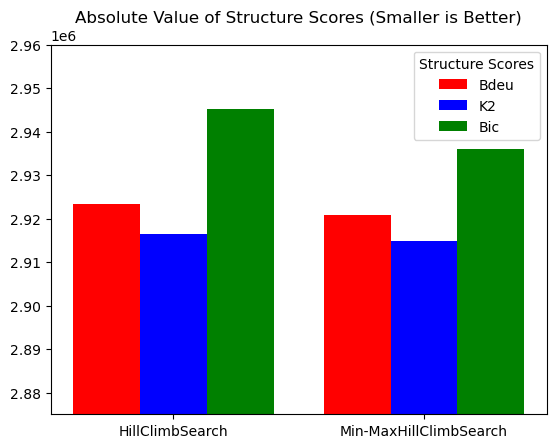

In [38]:
import matplotlib.pyplot as plt

initial_positions = [1, 4]
bar_width = 0.8
positions = []
x_tick_positions = []
x_tick_labels = ['HillClimbSearch', 'Min-MaxHillClimbSearch']
plot_title = 'Absolute Value of Structure Scores (Smaller is Better)'
legend_title = 'Structure Scores'
for i in initial_positions:
    group_positions = [i + j * bar_width for j in range(len(structure_scores_hc.keys()))]
    x_tick_position = group_positions[0] + (group_positions[-1] - group_positions[0]) / 2
    x_tick_positions.append(x_tick_position)
    positions.append(group_positions)
xs = zip(*positions)
colors = ['red', 'blue', 'green']
labels = ['Bdeu', 'K2', 'Bic']
heights = zip(structure_scores_hc.values(), structure_scores_mmhc.values())
for x, h, c, l in zip(xs, heights, colors, labels):
    h = np.abs(np.array(h))
    plt.bar(x, h, width=bar_width, color=c, label=l)
plt.legend(title=legend_title)
plt.xticks(x_tick_positions, labels=x_tick_labels)
plt.ylim((2875000, 2960000))
plt.title(plot_title)
plt.show()

# 8 Causal Inference
In the last part of this project, we used Bayesian Network models as classifiers in order to predict the class of a feature. In this part of the project, we will be making a different type of prediction that can only be made with Causal Bayesian Networks called Causal Inference.

In Causal Inference, we make predictions about the probability that particular features in the data will attain particular values given a set of so-called interventions. When an intervention is made, the values of the features that we are intervening on are manually set to particular values. In effect, we are changing the underlying distribution that generates the events to a different distribution in which the values of the intervened features attain our chosen values with a probability of 1. In practice, this corresponds to situations in which, instead of observing the values of features from a sample of the population, we instead first somehow force the population to attain specific values for some of the features, and then we sample the population to observe its features. It is also possible to make predictions by both intervening on some of the features and at the same time conditioning on others.

In theory, the interventional queries that can be made are numerous because we are free to choose any number of features whose probabilities we want to predict, any number of features that we want to intervene on with chosen values, and any number of features to condition on with chosen values. For the purposes of this project, we will only query a relatively small subset of them. Specifically, we will only do queries where we want to predict the probability of only one of the features when we intervene on only one other feature without conditioning on any others. Therefore, for a given feature, queries will be done by intervening on each of the other features for each of their possible values. We will then compare the probabilities that we obtain with the probability of observing that feature in the distribution when there is no intervention.

## 8.1 Generating Queries

Traning model

Loaded model


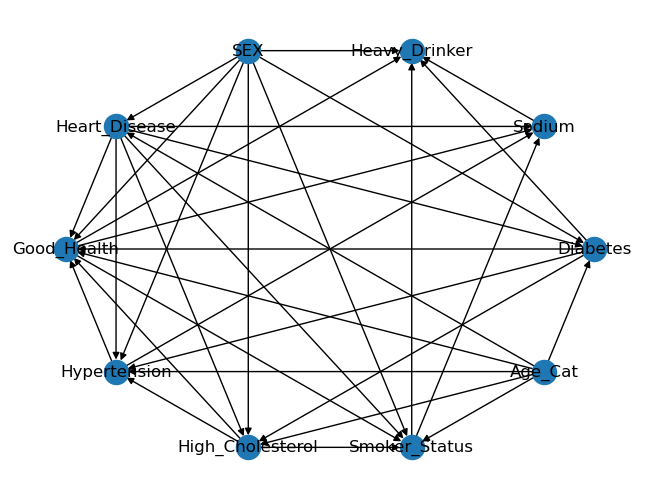

In [39]:
path = '../Data/inference_model.pkl'
if os.path.exists(path):
    with open(path, 'rb') as f:
        inference_model = pickle.load(f)
        print('Loaded model')
else:
    temp_df = drop_low_counts(pd.concat([X, y], axis=1), 0.01, verbose=True)
    X_drop = temp_df.drop(columns='Heart_Disease')
    y_drop = temp_df['Heart_Disease']
    del(temp_df)
    
    inference_model = BayesianModel(graph_search_algo=HillClimbSearch, black_list=black_list, estimator=BayesianEstimator).fit(X_drop, y_drop)
    print('Model trained')
    
    with open('./inference_model.pkl', 'wb') as f:
        pickle.dump(inference_model, f)
        
import networkx as nx
import matplotlib.pyplot as plt

nx.draw_shell(inference_model, with_labels=True)
plt.show()

Initializing causal inference object

In [40]:
from pgmpy.inference.CausalInference import CausalInference

inference = CausalInference(inference_model)

Function that takes as input a DiscreteFactor object (the output of the causal inference algorithm) and transforms it into a pandas series. Will be used for building a pandas dataframe summarizing the results.

In [41]:
def discrete_factor_to_series(factor, name=None):
    variables = factor.scope()
    n_states = 1
    for cardinality in factor.get_cardinality(variables).values():
        n_states = n_states * cardinality
    state_indices = list(range(n_states))
    assignments = factor.assignment(state_indices)
    state_names = []
    for assignment in assignments:
        state_name = ''
        for i, tuple_ in enumerate(assignment):
            if i != 0:
                state_name = state_name + '__'
            state_name = state_name + tuple_[0] + '_' + tuple_[1]
        state_names.append(state_name)
    states_dicts = [{state[0]:state[1] for state in assignment} for assignment in assignments]
    values = [round(factor.get_value(**dict_), 4) for dict_ in states_dicts]

    return pd.Series(values, index=state_names, name=name)

Generating results of causal queries

In [42]:
path = '../Data/inference_results.pkl'
if not os.path.exists(path):
    #Get the data and column names from the model.
    X_ = vars(inference)['model'].X_
    y_ = vars(inference)['model'].y_
    df_ = pd.concat([X_, y_], axis=1)
    features = df_.columns

    #Loop that generates results of causal queries and stores them in a dictionary.
    #For each feature, this loop will generate a dataframe that contains the 
    #probabilities of each of its classes under the intervention of every class of
    #all other features.
    inference_results = {}
    for feature in df_.columns:
        predecessors_states = {}
        for predecessor in inference_model.predecessors(feature):
            predecessors_states[predecessor]= list(df_[predecessor].unique())

        #Generating dictionary containing the resulting discrete factor of every
        #causal query made. This dictionary will eventyally be the input to the 
        #auxiliary function discrete_factor_to_series, which converts it to a
        #series. These series will then be the columns of the dataframe that
        #we want to generate.
        phi = {}
        phi['No_intervention'] = inference.query([feature])
        for predecessor, states in predecessors_states.items():
            for value in states:
                name = f'{predecessor}_{value}'
                phi[name] = inference.query([feature], do={predecessor:value})

        #Loop that converts the discrete factors into series.
        series_list = []
        for name, factor in phi.items():
            series_list.append(discrete_factor_to_series(factor, name))
    
        #Loop that uses the series obtained in the previous loop to build the
        #dataframe.
        infer_df = pd.DataFrame()
        columns = []
        for series in series_list:
            columns.append(series.name)
            infer_df = pd.concat([infer_df, series], axis=1)
        infer_df.columns = columns
        infer_df = infer_df.T
    
        inference_results[feature] = infer_df

    #This loop adds extra columns to the dataframes generated in the previous
    #loop. These columns contain the difference in probability between the 
    #propability prediction without the intervention and with the 
    #intervention.
    for feature, df in inference_results.items():
        for column in df.columns:
            base_value = df[column][0]
            new_column = df[column] - base_value
            new_column_name = column + '_diff'
            insert_index = df.columns.get_loc(column) + 1
            df.insert(insert_index, new_column_name, new_column)
        inference_results[feature] = df

    with open(path, 'wb') as f:
        pickle.dump(inference_results, f)

else:
    with open(path, 'rb') as f:
        inference_results = pickle.load(f)
    print('Loaded inference results')

Loaded inference results


## 8.2 Results

### 8.2.1 Query Results
This dataframe contains the results of all of the causal queries done. Each dataframe contains the results of the queries on one of the features. The columns correspond to each of the classes of the feature whose probabilities we want to find. Each row corresponds to a particular intervention with a particular value of the intervention. The values of the tables are the probability of an individual having the class of the feature shown on the column given that we intervene as shown on the index of the row.

In [43]:
for df in inference_results.values():
    print(df)
    print()

                      Good_Health_1  Good_Health_1_diff  Good_Health_2  \
No_intervention              0.8165              0.0000         0.1835   
Hypertension_1               0.7532             -0.0633         0.2468   
Hypertension_2               0.8553              0.0388         0.1447   
High_Cholesterol_1           0.7843             -0.0322         0.2157   
High_Cholesterol_2           0.8434              0.0269         0.1566   
High_Cholesterol_999         0.7558             -0.0607         0.2442   
Age_Cat_5                    0.7897             -0.0268         0.2103   
Age_Cat_4                    0.8222              0.0057         0.1778   
Age_Cat_6                    0.7700             -0.0465         0.2300   
Age_Cat_3                    0.8747              0.0582         0.1253   
Age_Cat_2                    0.9027              0.0862         0.0973   
Age_Cat_1                    0.9219              0.1054         0.0781   
Diabetes_2                   0.8455   

### 8.2.2 Comparison of Probabilites With and Without Interventions
For each class of each feature, a bar plot is generated where the height of each bar corresponds to the probability difference between the probability with and without the intervention. Therefore, each bar tells you how much the probability of an individual belonging to a particular class will change under a given intervention.

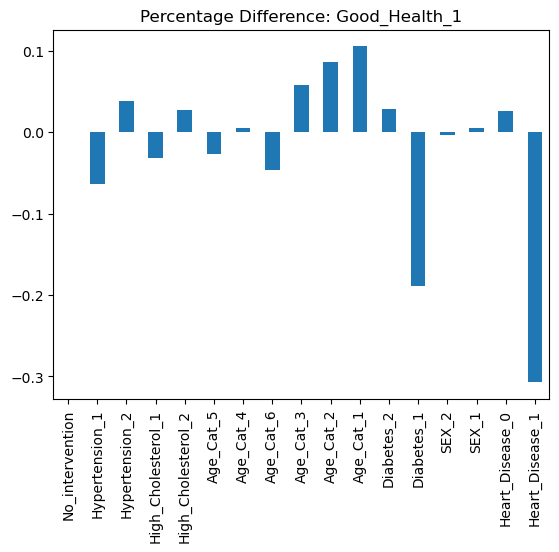

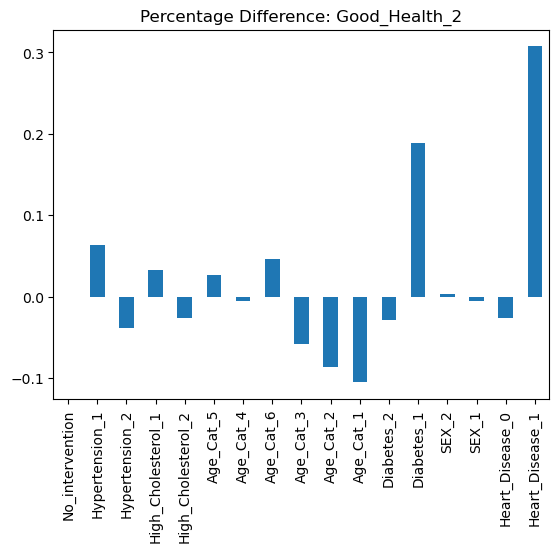

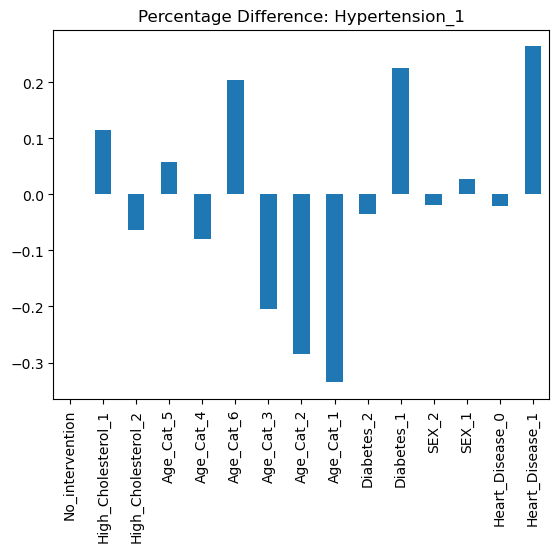

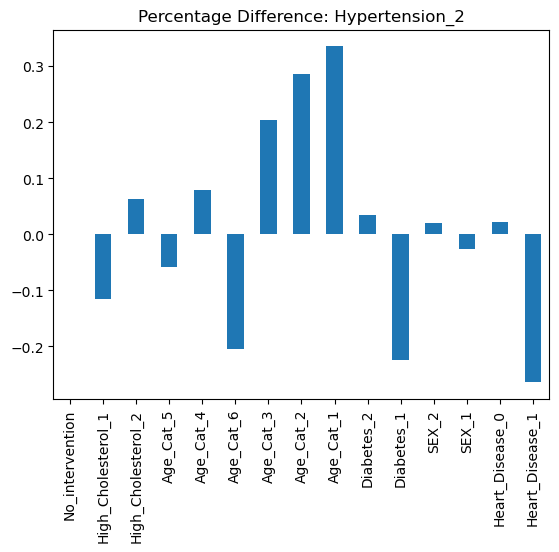

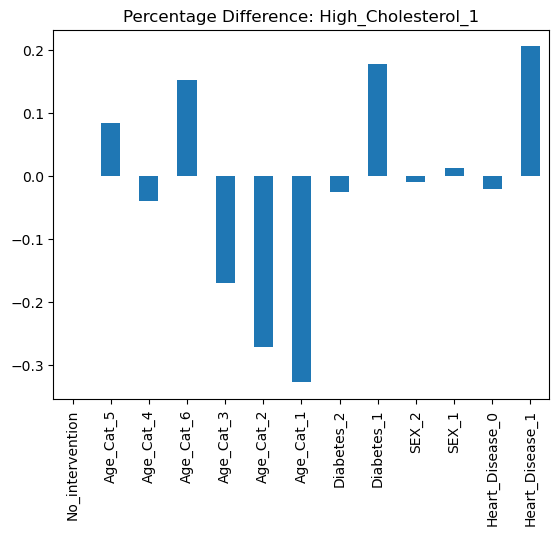

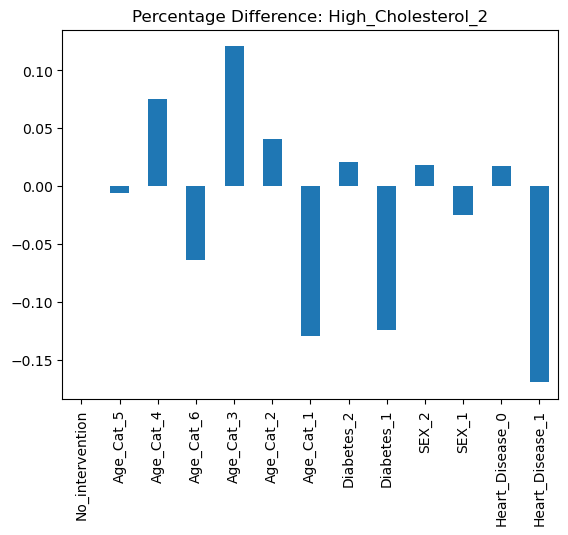

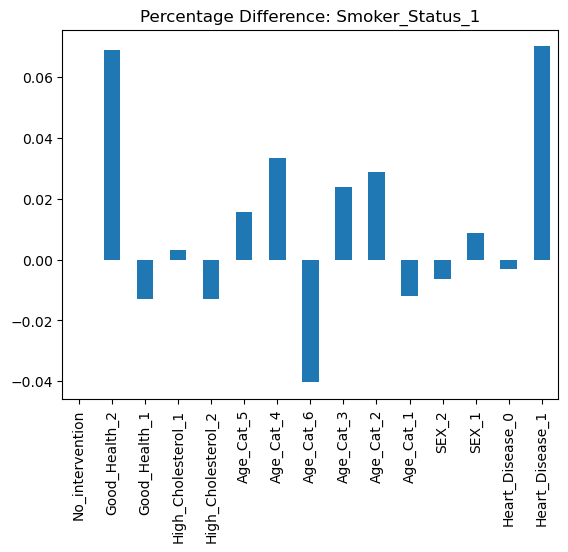

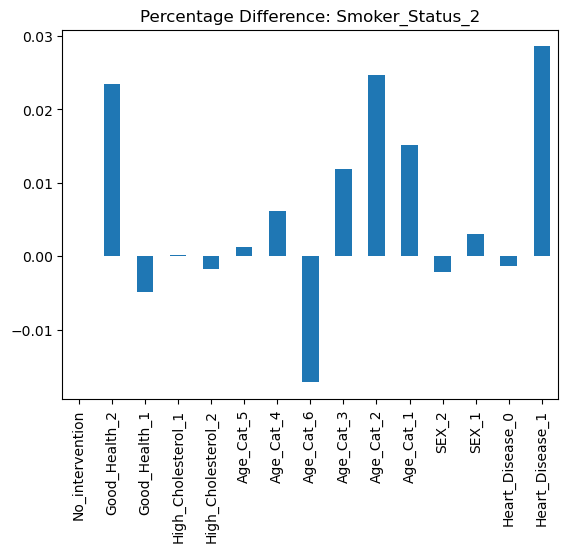

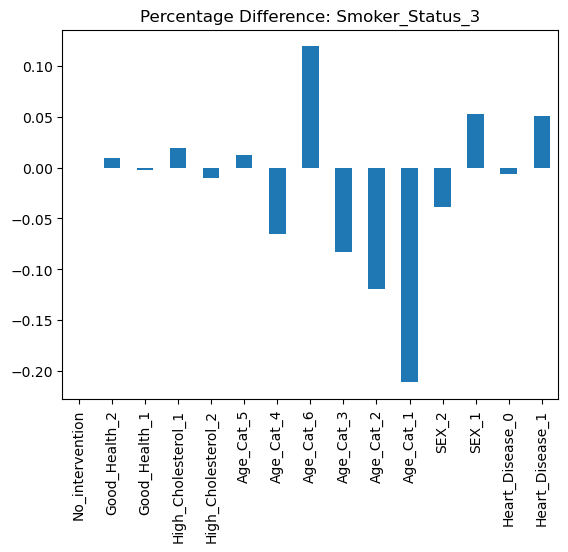

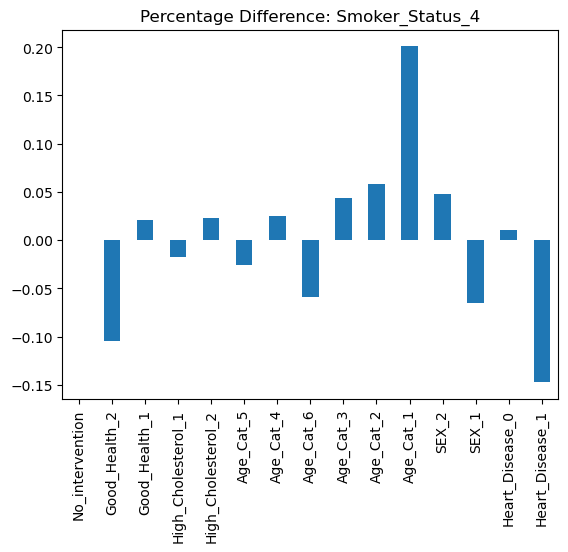

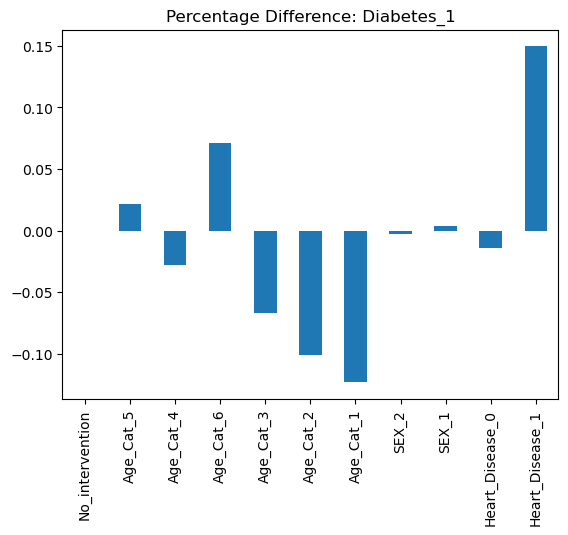

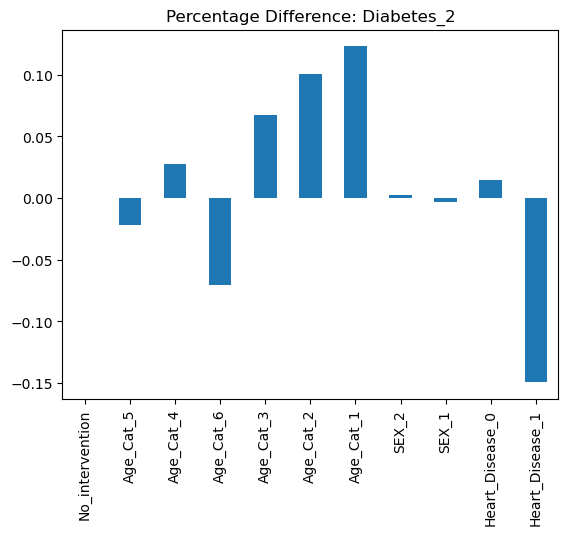

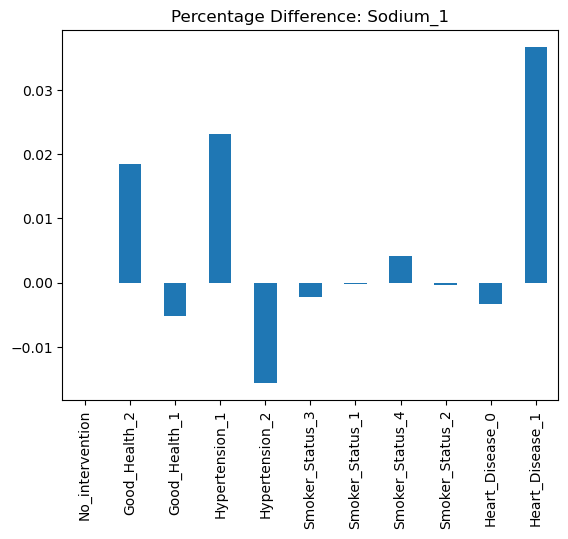

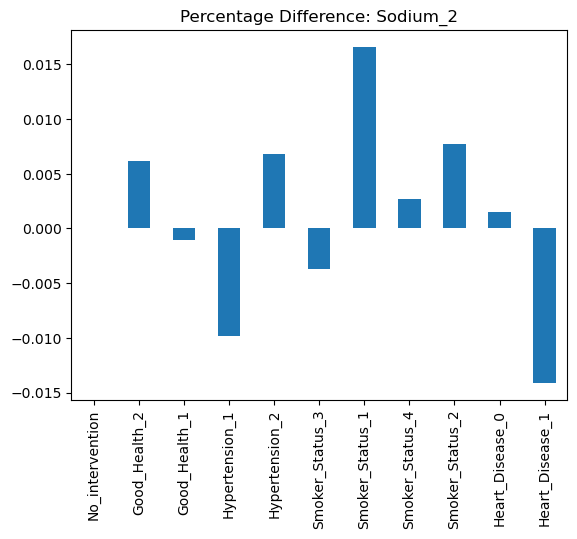

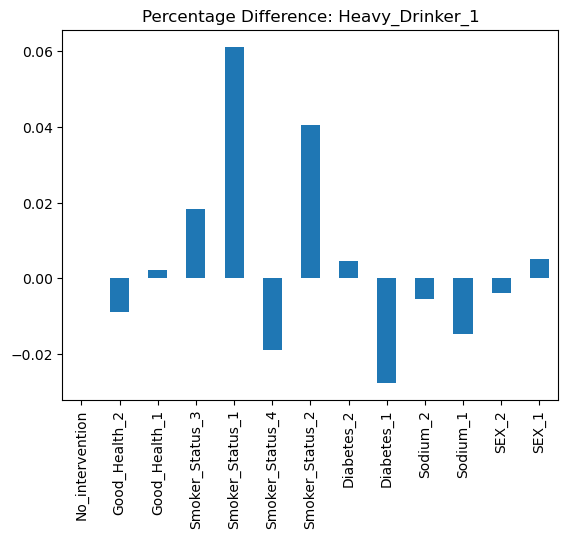

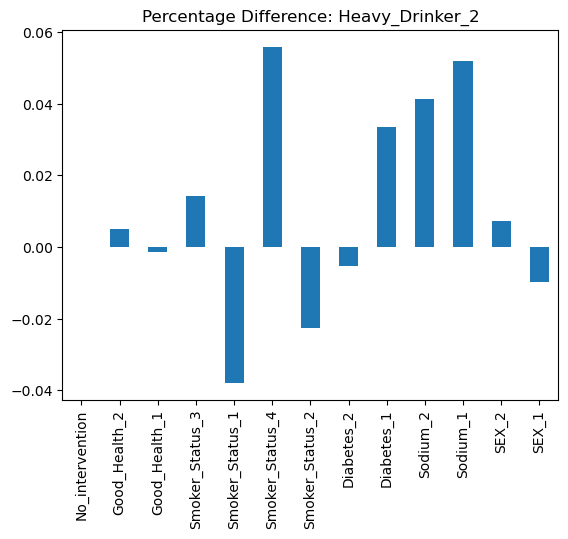

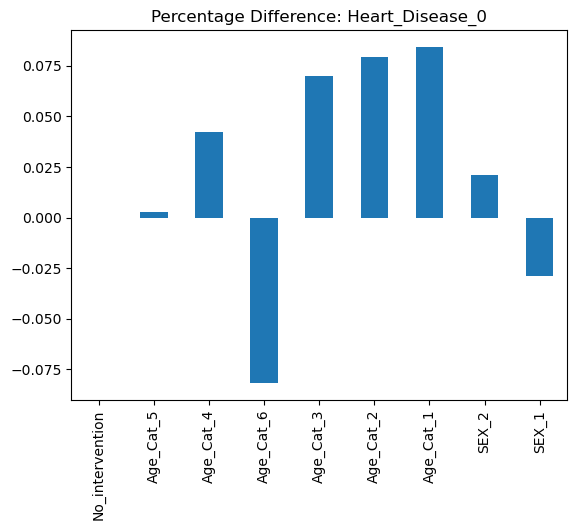

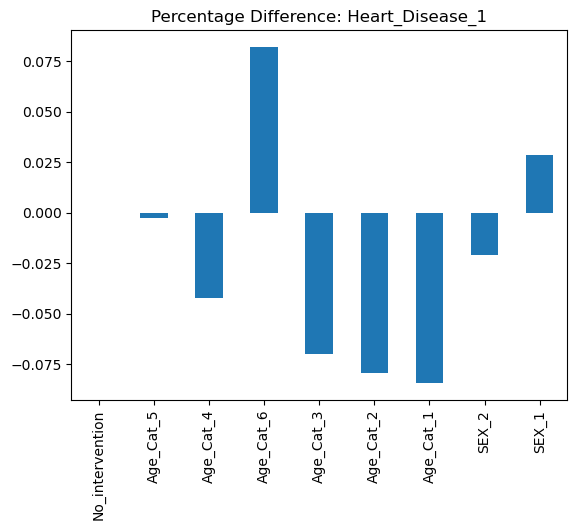

In [44]:
import re

for df in inference_results.values():
    #If the feature has no predecessors, skip because there is nothing to show. 
    if df.shape[0] != 1:
        #These two lines of code gets rid of all indices and columns that end
        #in either _9, _99, or _999; these are not interesting classes.
        indices = [index for index in df.index if not re.search("_9*$", index)]
        columns = [column for column in df.columns if not re.search("_9*$", column)]
        df = df = df.loc[indices, columns]
        n_columns = len(columns)
        for i in range(1, n_columns, 2):
            df.iloc[:, i].plot.bar()
            plt.title('Percentage Difference: ' + columns[i - 1])
            plt.show()


# 9 Summary and Conclusions
In this project, we proceeded to build Bayesian Network models using data about the prevalence of health features in a sample from the U.S. adult population. To simplify the model, we only included ten features: Good_Health, Hypertension, High_Cholesterol, Smoker_Status, Age_Cat (Age Category), Diabetes, Sodium, Heavy_Drinker, Heart_Disease, and SEX. For each of these features, the majority of the population has a class value of either '1' (has the feature) or '2' (does not have the feature). The other classes correspond to categories such as "unknown" or "chose not to answer". 

Our goals in building the Bayesian Models were many. First, to use them as classifiers. In other words, as tools for predicting the class of a feature on previously unseen data. Second, to attempt to understand the causal structure of the data. One of the outputs of the algorithms is a directed acyclic graph (DAG) that represents the data, with nodes representing the features and arrows connecting them. If an arrow points from one feature to another, this could be interpreted as the parent feature being "the cause" of the child node, "the effect". Therefore, these types of models go beyond discovering correlations in the data and can establish whether there is a causal link between two features. Third, once the models are built, they can be used to do "causal inference". This means using them to make predictions under interventions; in an intervention, the underlying distribution is first changed so that the values of the features that we intervened on attain a predetermined value with probability 1 and then we use this new distribution to make predictions about the values of other features.

In Chapter 4, we built two models using two different graph search algorithms: Hill Climb Search and Max-Min Hill Climb Search. We then used those models to make predictions about the class of one of the features on unseen data; specifically, to make predictions about whether an individual has heart disease or not given the values of other features. The results show that these two models have a good performance on these tasks; for Hill Climb Search, the recall and roc auc scores are, respectively, 0.81 and 0.83, while for Min-Max Hill Climb these scores are 0.80 and 0.83. Surprisingly, these results were similar to the ones from the non-causal algorithm XGBoost, which had recall and roc auc scores, respectively, of 0.81 and 0.84. We can conclude from this that, even though Bayesian Networks models are not classification models (in the sense that they were not developed to specifically address classification problems), they still do a very good job in classification tasks. 

We also attempted to use another Bayesian Network algorithm: the PC algorithm. However, for reasons that are still not well understood, the output of the algorithm is not a proper DAG because it contains a cycle; it, therefore, cannot be used to make predictions. This is regrettable because the PC algorithm has the advantage of also being able to find the so-called class PDAG that represents the data. This class PDAG doesn't represent a single DAG, but rather an equivalence class of many DAGs such that each graph in the class can represent the conditional independencies found in the data. In a PDAG, some of the edges are undirected, and they will only be directed if it is directed in all of the graphs that form part of the equivalent class. If it is not directed, it means that the direction of the arrow is different in different members of the equivalent class. The advantage of this is that the output of the algorithm gives us a bigger number of possible graphs that could represent the causal relationships in the data. Domain knowledge could then be used to choose the direction of the unoriented edges. The reasons for the failure of the algorithm to produce a proper DAG will be investigated in a future study.

One of the outputs of the models was a DAG that represents the conditional independencies found in the data. These can be also given a causal interpretation so that when there is an arrow pointing from one feature to another, it means that the parent is the "cause" and the child is the "effect". However, the algorithm utilizes the concept of conditional independence to build the graph, not causality. In fact, the causal direction between two features cannot be determined from observational data because it is a notion that depends on how distributions change under interventions. Therefore, while the output of each model is the graph that has the highest score when evaluated on how accurately it represents the conditional independencies in the data, this does not guarantee that it will return a DAG with the correct causal structure; it might be the case that a lower scoring graph has the correct causal structure. In fact, some of the edges found in the resultant graphs don't make much intuitive sense. For example, in the DAG found for the Hill Climb Search algorithm shown in section 4.1.3, there is an arrow pointing from the feature Heart_Disease to the feature Heavy_Drinking. If given a causal interpretation, this would imply that, if a person has heart disease, this "causes" the person to develop "heavy drinking". However, it makes more intuitive sense that "heavy drinking" causes "heart disease". This is why it is important that, when trying to discover causal connections between features, the building of the graphs should be supplemented with domain knowledge that informs the model builder whether particular edges should be disallowed and whether particular edges should always be there.

In Chapter 5, we applied cross-validation on the models built in the previous chapter to verify if they were overfitting the data. For Hill Climb Search, the standard deviations for the recall and roc auc scores were, respectively, 0.0065 and 0.0028; for Min-Max Hill Climb Search, the values were 0.0074 and 0.0033. This shows that the Bayesian Network models, when used as classifiers, were not overfitting the data.

In Chapter 6, algorithms used in Chapter 4 were built, but this time their performances were evaluated using structure scores instead of classification metrics. These structure scores (BDeu, K2, and Bic) measure the degree to which the DAGs found with the algorithms can accurately represent the conditional independencies found in the data. We found that the Min-Max Hill Climb Search algorithm has slightly higher scores, but this difference is likely not very significant.

In Chapter 7, we used one of the built Bayesian Models to do causal inference. For every class of every feature, we calculated the probability of having that class value occurring in the population given every way that an intervention on a single feature could be made. Each intervention corresponds to choosing one of the predecessors of the feature of interest, choosing one of its values so that it occurs with a probability of 1, and then calculating the probability of the feature of interest. For every single one of these interventions, the difference in probability with and without an intervention was found. The results are shown on the bar graphs in section 7.2.2. 

What is useful about the bar graphs in section 7.2.2 is that, assuming the graph of the model is an accurate representation of the causal relationships between the variables, it tells you what are the sorts of interventions that a medical practitioner can make (such as, for example, telling a patient to lower their cholesterol consumption) to minimize the risk of, for example, heart disease.